# Motivação matemática das redes neurais artificiais

## Implementação

Autora: Maria Eduarda Dall Negro Mochinski

Esse notebook contém os códigos utilizados no desenvolvimento dos experimentos numéricos da Monografia.



## Importação das bibliotecas necessárias

In [1]:
import pandas as pd # manipulacao de dados tabulares
import numpy as np # operacoes com vetores e matrizes
from sklearn.datasets import fetch_openml # origem do dataset
from sklearn.model_selection import StratifiedKFold # separacao randomica do conj. de dados
import time # medida de tempo
from itertools import product as iter_product # funcoes de combinacoes de elementos
from sklearn.metrics import confusion_matrix # matriz de confusao dos resultados
from matplotlib import pyplot as plt # graficos
import seaborn as sns # graficos auxiliares

## Definições para o problema específico

In [2]:
# tamanho ultima camada (numero de classes possiveis)
n = 10
# numero de elementos no conjunto de dados de treino
m = 60000

## Importação e manipulação inicial dos dados

In [3]:
# importacao e manipulacao inicial dos dados
def importar_dados():
    # obter base de dados
    mnist = fetch_openml('mnist_784',version=1)

    # transformar em matriz
    data = np.array(mnist['data'])

    # selecionar dados treino
    # dados de entrada
    X_train = data[0:m].T 
    # saida esperada
    Y_train = mnist['target'][0:m]
    # converter para numerico
    Y_train = Y_train.astype(np.uint8)
    # normalizar valores
    X_train = X_train / 255.

    # selecionar dados teste
    # dados de entrada
    X_test = data[m:].T 
    # saida esperada
    Y_test = mnist['target'][m:]
    # converter para numerico
    Y_test = Y_test.astype(np.uint8)
    # normalizar valores
    X_test = X_test / 255.

    return X_train, Y_train, X_test, Y_test, data


X_train, Y_train, X_test, Y_test, data = importar_dados()

# definir tamanho primeira camada:
o = X_train.shape[0]

c:\Users\dudin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Exploração dos dados

In [6]:
print('Y_train')
unique_train, counts_train = np.unique(Y_train, return_counts=True)
dic_train=dict(zip(unique_train, counts_train))
dic_train={i:round(dic_train[i]/len(Y_train),3) for i in unique_train}
print(dic_train)
print('Y_test')
unique_test, counts_test = np.unique(Y_test, return_counts=True)
dic_test=dict(zip(unique_test, counts_test))
dic_test={i:round(dic_test[i]/len(Y_test),3) for i in unique_test}
print(dic_test)

Y_train
{0: 0.099, 1: 0.112, 2: 0.099, 3: 0.102, 4: 0.097, 5: 0.09, 6: 0.099, 7: 0.104, 8: 0.098, 9: 0.099}
Y_test
{0: 0.098, 1: 0.114, 2: 0.103, 3: 0.101, 4: 0.098, 5: 0.089, 6: 0.096, 7: 0.103, 8: 0.097, 9: 0.101}


Cada classe, tanto no conjunto de treino, quanto o conjunto de teste, tem aproximadamente 10% da quantidade total de elementos. Isso mostra que a base é balanceada.

## Definição das funções do algoritmo

In [13]:
# transformar rotulo numerico em vetor canonico de classe
def one_hot(Y):
    size = n
    one_hot_Y = np.zeros((n,Y.size))
    one_hot_Y[Y,np.arange(Y.size)] = 1 
    return one_hot_Y

# implementacao funcao sigmoide
def sigmoid(x):
    return (1/(1+np.exp(-x)))

# implementacao derivada sigmoide
def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

# implementacao funcao tanh
def tanh(x):
    return ((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))

# implementacao derivada tanh
def tanh_deriv(x):
    t = tanh(x)
    return 1-t*t

# inicializacao de parametros (GLOROT; BENGIO, 2010)
def inicializar_parametros(o,p,n):
    W1 = np.random.uniform(-(1/np.sqrt(o)),(1/np.sqrt(o)),(p,o))
    b1 = np.zeros((p,1))
    W2 = np.random.uniform(-(1/np.sqrt(p)),(1/np.sqrt(p)),(n,p))
    b2 = np.zeros((n,1))  
    return W1, b1, W2, b2

# implementacao forward propagation
def forward_prop(W1, b1, W2, b2, A0):
    Z1 = W1.dot(A0) + b1
    A1 = tanh(Z1) 
    Z2 = W2.dot(A1) + b2
    try:
        A2 = sigmoid(Z2)
    except Warning:
        print('warning',max(A2))
    return Z1, A1, Z2, A2

# implementacao backpropagation
def backprop(A0, Z1,A1,Z2,A2,Y,W2):
    m = A0.shape[1]
    dCdA2 = (1/m) *(A2-Y) 
    dCdZ2 = np.multiply(dCdA2, sigmoid_deriv(Z2)) 
    dCdW2 = dCdZ2.dot(A1.T)
    dCdb2 = np.sum(dCdZ2,1).reshape(Z2.shape[0],1)
    dCdA1 = W2.T.dot(dCdZ2)
    dCdZ1 = np.multiply(dCdA1, tanh_deriv(Z1))
    dCdW1 =  dCdZ1.dot(A0.T)
    dCdb1 =  np.sum(dCdZ1,1).reshape(Z1.shape[0],1)
    return dCdW1, dCdb1, dCdW2, dCdb2

# atualizacao dos parametros
def update_parameters(W1,b1,W2,b2,dCdW1, dCdb1, dCdW2, dCdb2,alpha):
    W1 = W1 - alpha * dCdW1
    b1 = b1 - alpha * dCdb1
    W2 = W2 - alpha * dCdW2
    b2 = b2 - alpha * dCdb2
    return W1, b1, W2, b2

# retorna a classe selecionada pelo algoritmo
def get_predictions(A2):
    return np.argmax(A2,0)

# implementacao acuracia
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y)/Y.size

# =============================
# Implementacao do Algoritmo 1
# =============================
# algoritmo de treinamento da rede
def gradient_descent(A0,Y, o,p,n, alpha, iterations):
    print('o:',o,'p',p,'n',n, 'alpha',alpha, 'iterations', iterations)
    # Passo 1: inicializar os parametros
    W1, b1, W2, b2 = inicializar_parametros(o,p,n)
    # formatar rotulos para vetores canonicos
    Y_hot = one_hot(Y)
    # inicio da iteracao:
    for i in range(iterations):
        # Passo 2: Forward pass
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, A0)
        # Passo 3: Backpropagation
        dCdW1, dCdb1, dCdW2, dCdb2 = backprop(A0, Z1,A1,Z2,A2,Y_hot,W2)
        # Passo 4: Atualizacao dos parametros
        W1, b1, W2, b2 = update_parameters(W1,b1,W2,b2,dCdW1,dCdb1, dCdW2, dCdb2,alpha)
        if i%50==0:
            # mostrar avanco das iteracoes
            print('Iteration:',i)
            print(get_accuracy(get_predictions(A2),Y))
    print('Iteration:',i)  
    accuracy_train = get_accuracy(get_predictions(A2),Y)
    print(accuracy_train)

    # retornar parametros otimos encontrados e acuracia de treino
    return W1, b1, W2, b2, accuracy_train

# dado os parametros otimos, retorna predicoes para dados ineditos
def make_predictions(X,W1,b1,W2,b2):
    _, _, _, A2 = forward_prop(W1,b1,W2,b2,X)
    predictions = get_predictions(A2)
    return predictions

## Processos auxiliares

Validação cruzada e *grid search*

In [16]:
def cross_validation(X,Y,param_modelo, random_state, n_splits=3):
    # cria particoes dos dados
    skfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=150)

    # inicializar vetores para guardar resultados
    metrica_treino = []
    metricas = []
    tempo_treino = []
    aprox = []
    for train_index, test_index in skfolds.split(X.T, Y):
        # separar bases de treino e validacao
        X_train_fold = X[:,train_index]
        Y_train_fold = Y[train_index]
        X_test_fold = X[:,test_index]
        Y_test_fold = Y[test_index]

        # definir estado randomico para obter resultados reproduziveis
        np.random.seed(random_state)
        # medir tempo de treinamento
        t = time.process_time()
        # fazer treinamento
        W1, b1, W2, b2, accuracy_train = gradient_descent(X_train_fold,Y_train_fold,**param_modelo)
        elapsed_time = time.process_time() - t
        metrica_treino.append(accuracy_train)
        tempo_treino.append(elapsed_time)
        aprox.append([W1, b1, W2, b2])

        # testar na base de validacao
        dev_predictions = make_predictions(X_test_fold, W1, b1, W2, b2)
        accuracy = get_accuracy(dev_predictions, Y_test_fold)

        metricas.append(accuracy)

    # calcular metricas medias
    train_accuracy = sum(metrica_treino) / len(metrica_treino)
    validation_accuracy = sum(metricas) / len(metricas)
    tempo_medio = sum(tempo_treino) / len(tempo_treino)
    results = {'score_medio': validation_accuracy, 'scores': metricas,'score_medio_treino': train_accuracy, 'scores_treino': metrica_treino,'tempo_medio':tempo_medio, 'tempo_treino': tempo_treino}
    return results,aprox

def grid_search(X,Y,o,n, random_state, vet_p, vet_alpha, vet_iterations, n_splits=3):
    # fazer lista com todas as combinacoes possiveis de parametros
    comb_parametros = [{"o": o,'p':i[0],"n": n,'alpha': i[1],'iterations':i[2]} for i in iter_product(vet_p,vet_alpha,vet_iterations)]
    lista_dicts = []
    print(comb_parametros)
    # arquivo para registrar resultados
    with open('output_gridsearch2.txt','w') as output_file:
        # para cada combinacao rodar uma validacao cruzada e registrar resultados
        for i in comb_parametros:
            print(i)
            results, aprox = cross_validation(X,Y,i, random_state, n_splits=n_splits)
            results['parametros'] = i
            lista_dicts.append(results)
            output_file.writelines(str(results)+';\n')

    # formatar resultados
    df_results = pd.DataFrame(lista_dicts)
    # selecionar combinacao com melhor metrica de validacao
    linha_otima = df_results.loc[df_results['score_medio'].idxmax()]
    parametros_otimos = linha_otima['parametros']
    score_validacao = linha_otima['score_medio']

    return score_validacao, parametros_otimos, df_results

In [17]:
# grid search
# definir espaço de busca
# numero de neuronios na camada intermediaria
vet_p=[10,20,30,40,50,70,80,90,100,120,130,150]
# tamanho de passo
vet_alpha=[0.1,0.5,1,2,3,4]
# numero de iteracoes
vet_iterations=[200]

# fazer a procura
score, param, df = grid_search(X_train,Y_train,o=784,n=10, random_state=100, vet_p=vet_p, vet_alpha=vet_alpha, vet_iterations=vet_iterations, n_splits=3)
# mostrar melhor score e hiperparametros
print('Melhor acurácia de validação:',score)
print('Hiperparâmetros:',param)

[{'o': 784, 'p': 10, 'n': 10, 'alpha': 0.1, 'iterations': 200}, {'o': 784, 'p': 10, 'n': 10, 'alpha': 0.5, 'iterations': 200}, {'o': 784, 'p': 10, 'n': 10, 'alpha': 1, 'iterations': 200}, {'o': 784, 'p': 10, 'n': 10, 'alpha': 2, 'iterations': 200}, {'o': 784, 'p': 10, 'n': 10, 'alpha': 3, 'iterations': 200}, {'o': 784, 'p': 10, 'n': 10, 'alpha': 4, 'iterations': 200}, {'o': 784, 'p': 20, 'n': 10, 'alpha': 0.1, 'iterations': 200}, {'o': 784, 'p': 20, 'n': 10, 'alpha': 0.5, 'iterations': 200}, {'o': 784, 'p': 20, 'n': 10, 'alpha': 1, 'iterations': 200}, {'o': 784, 'p': 20, 'n': 10, 'alpha': 2, 'iterations': 200}, {'o': 784, 'p': 20, 'n': 10, 'alpha': 3, 'iterations': 200}, {'o': 784, 'p': 20, 'n': 10, 'alpha': 4, 'iterations': 200}, {'o': 784, 'p': 30, 'n': 10, 'alpha': 0.1, 'iterations': 200}, {'o': 784, 'p': 30, 'n': 10, 'alpha': 0.5, 'iterations': 200}, {'o': 784, 'p': 30, 'n': 10, 'alpha': 1, 'iterations': 200}, {'o': 784, 'p': 30, 'n': 10, 'alpha': 2, 'iterations': 200}, {'o': 784, 

## Treinamento da rede usando os hiperparametros ótimos encontrados

In [19]:
param['iterations']=600
np.random.seed(100)
W1, b1, W2, b2, accuracy_train = gradient_descent(X_train,Y_train, **param)
print('Acurácia de treino:',accuracy_train)

o: 784 p 80 n 10 alpha 3 iterations 600
Iteration: 0
0.12366666666666666
Iteration: 50
0.7909
Iteration: 100
0.89535
Iteration: 150
0.9148666666666667
Iteration: 200
0.9228833333333334
Iteration: 250
0.9288666666666666
Iteration: 300
0.9335166666666667
Iteration: 350
0.9376333333333333
Iteration: 400
0.9412833333333334
Iteration: 450
0.94465
Iteration: 500
0.9469
Iteration: 550
0.9492
Iteration: 599
0.9511333333333334
Acurácia de treino: 0.9511333333333334


## Testar performance em base de dados inédita

In [20]:
Y_pred = make_predictions(X_test,W1,b1,W2,b2)
score_test = get_accuracy(Y_pred, Y_test)

# acuracia obtida:
print('Acurácia de teste:',score_test)

Acurácia de teste: 0.9486


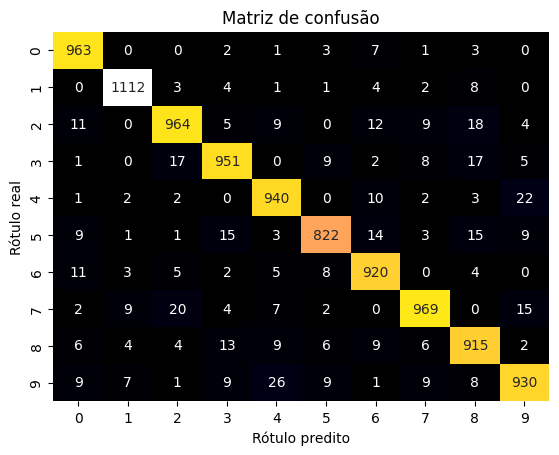

In [21]:
# Matriz de confusao
plt.axis('tight')
heat_map = sns.heatmap(confusion_matrix(Y_test,Y_pred),annot=True,fmt='g', cbar=False,cmap='gnuplot2')
heat_map.set(xlabel='Rótulo predito', ylabel='Rótulo real',title = 'Matriz de confusão')
# salvar figura
heat_map.get_figure().savefig('matriz_confusao.png')

In [22]:
# registrar resultados em tabela
df_test = pd.DataFrame({'y_test':Y_test,'y_pred':Y_pred})
df_test['correct']=df_test['y_test']==df_test['y_pred']

# indices em que o algoritmo errou a classificacao
ind_teste_erro = df_test[~df_test['correct']].index.tolist()
# indices em que o algoritmo acertou a classificacao
ind_teste_acerto = df_test[df_test['correct']].index.tolist()

In [23]:
# funcao auxiliar para plotar exemplos de imagens
def test_prediction(index, df,file_name = False):
    current_image = data[index].T/255
    prediction = df.loc[index,'y_pred']
    label = df.loc[index,'y_test']
    print("Prediction: ", prediction)
    print("Label: ", label)
    if prediction==label:
        print('Correct guess')
    else:
        print('Incorrect guess')
    current_image = current_image.reshape((28,28))*255
    fig, ax = plt.subplots(figsize=(5,5))
    fig = sns.heatmap(current_image,cbar=False,cmap='binary')
    fig.set(title=f'Rótulo real = {label}, Rótulo predito={prediction}')
    for _, spine in fig.spines.items(): 
        spine.set_visible(True) 
        spine.set_linewidth(1) 

    ax.tick_params(left=False, bottom=False,labelsize=False) 
    fig = fig.get_figure()
    if file_name:
        if file_name[-4:]!='.png':
            file_name = file_name+'.png'
        fig.savefig(file_name)

Prediction:  4
Label:  4
Correct guess


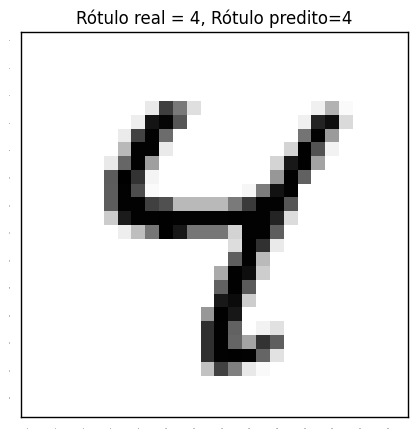

In [30]:
# plotar caso em que o algoritmo acertou
test_prediction(ind_teste_acerto[6], df_test, file_name=False)

Prediction:  6
Label:  1
Incorrect guess


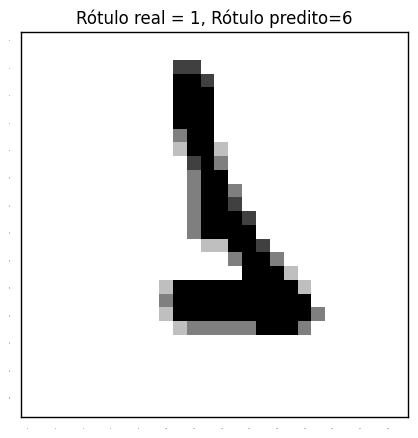

In [29]:
# plotar caso em que o algoritmo errou
test_prediction(ind_teste_erro[52], df_test, file_name=False)